In [1]:
#! /usr/bin/env python
# -*- coding:utf-8 -*-

import os
import argparse
import numpy as np
import cv2

import chainer
import chainer.functions as F
import chainer.links as L
from chainercv.datasets import DirectoryParsingLabelDataset

from chainer import Variable
from models.resnet50_fine_noABN import ResNet50_Fine_NoABN

import matplotlib.pyplot as plt
%matplotlib inline

/home/cocoa/.pyenv/versions/3.7.0/lib/python3.7/site-packages/chainer/_environment_check.py:89: UserWarning: 
--------------------------------------------------------------------------------
Multiple installations of CuPy package has been detected.
You should select only one package from from ['cupy-cuda101', 'cupy-cuda100', 'cupy-cuda92', 'cupy-cuda91', 'cupy-cuda90', 'cupy-cuda80', 'cupy'].
Run `pip list` to see the list of packages currently installed, then
`pip uninstall <package name>` to uninstall unnecessary package(s).
--------------------------------------------------------------------------------

  '''.format(name=name, pkgs=pkgs))


In [2]:
dataset = DirectoryParsingLabelDataset("../dataset/good_condition/")

In [248]:
label = 2
image = dataset.img_paths[2200]
print(image)
result = "result"
weight = "result/2019-09-18-13-24-02/model/2019-09-18-13-24-02_4-1_fold.npz"
classes = 8

../dataset/good_condition/HEALTHY/700201.jpg


In [249]:
# 注目したラベルの指定
category_label = label
print('we want {}'.format(category_label))
# pathと画像名に分割する。
#  "../../../tomato_topstem/HEALTHY/***.JPG"
# → parent = "../../../tomato_topstem/HEALTHY/" img_name = "***.JPG"
parent, img_name = os.path.split(image)
# inputした画像の保存先
input_name = '{}/{}'.format(result, 'input_' + img_name)
# heatmap画像の保存先
heatmap_name = '{}/{}'.format(result, 'heatmap_' + img_name)
# grad_cam＠画像の保存先
gradcam_name = '{}/{}'.format(result, 'gradcam_' + img_name)

we want 2


In [250]:
# 画像の読み込み
row_img = cv2.imread(image)
# リサイズ
img = cv2.resize(row_img.astype(np.float32), (224, 224)).transpose((2, 0, 1)) / 255.0
resize_img = img

# 次元を追加したい配列があったときに、次元を追加したい場所にnp.newaxisをおく
# ぶっちゃけよく分からない？
img = img[np.newaxis]

print('Load weight ...')
# モデルのセット
model = L.Classifier(ResNet50_Fine_NoABN(output=8))
# 重みのロード
chainer.serializers.load_npz(weight, model)

print('finish loading !')
# 画像の
# shape(1, 3, 224, 224)
input_img = Variable(img)

Load weight ...
finish loading !


In [251]:
# 推測
with chainer.using_config('train', False):
    pred = model.predictor(input_img)

In [252]:
# 推測
with chainer.using_config('train', False):
    pred = model.predictor(input_img)

# 各クラスの確率の計算
# こんな感じ[1.82548277e-02   7.42741069e-09   9.81745183e-01]
probs = F.softmax(pred).data[0]
print(np.argsort(probs)[::-1])
top = np.argsort(probs)[::-1][0]
print('top1 prob : {}'.format(top))

pred.zerograd()
pred.grad = np.zeros([1, classes], dtype=np.float32)
pred.grad[0, top] = 1
pred.backward(True)

feature = model.predictor.cam.data[0]
grad = model.predictor.cam.grad[0]

cam = np.ones(feature.shape[1:], dtype=np.float32)
weights = grad.mean((1, 2))*5000

[2 1 3 7 6 5 0 4]
top1 prob : 2


In [253]:
for i, w in enumerate(weights):
    cam += feature[i] * w

cam = cv2.resize(cam, (224, 224))
cam = np.maximum(cam, 0)
heatmap = cam / np.max(cam)
heatmap = cv2.applyColorMap(np.uint8(255*heatmap), cv2.COLORMAP_JET)

image = img[0, :].transpose(1, 2, 0) * 255
image -= np.min(image)
image = np.minimum(image, 255)
cam_img = np.float32(heatmap) + np.float32(image)
cam_img = 255 * cam_img / np.max(cam_img)

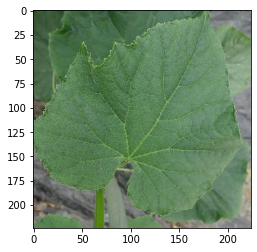

In [254]:
plt.imshow(cv2.cvtColor(image/255, cv2.COLOR_BGR2RGB))

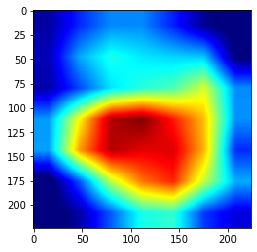

In [255]:
plt.imshow(cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB))

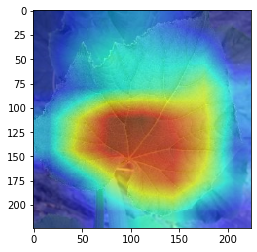

In [256]:
plt.imshow(cv2.cvtColor(cam_img / 255, cv2.COLOR_BGR2RGB))